In [237]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image


TensorFlow version: 2.16.1
Keras version: 3.3.3


4 classes:
['Cristiano Ronaldo', 'Erling Haaland', 'Lionel Messi', 'Sergio Ramos']


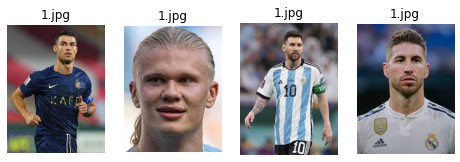

In [238]:
# The images are in the data/shapes folder
data_folder = '../../img/jugadores'

# Get the class names
classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

In [239]:

img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 72 images belonging to 4 classes.


Preparing validation dataset...
Found 28 images belonging to 4 classes.
Data generators ready


In [240]:
# Define a CNN classifier network

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Flatten the feature maps 
model.add(Flatten())

# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

C:\Users\Laura Rodríguez\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 123, 123, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 56, 56, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 23, 23, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │        15,492 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,772 (362.39 KB)

 Trainable params: 92,772 (362.39 KB)

 Non-trainable params: 0 (0.00 B)

None


In [241]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 60
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/60
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1667 - loss: 1.4005

C:\Users\Laura Rodríguez\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.1825 - loss: 1.4453 - val_accuracy: 0.2500 - val_loss: 1.4050
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2333 - loss: 1.4239 - val_accuracy: 0.2500 - val_loss: 1.3933
Epoch 3/60


c:\ProgramData\Anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2889 - loss: 1.3872 - val_accuracy: 0.2143 - val_loss: 1.3886
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2500 - loss: 1.3762 - val_accuracy: 0.1786 - val_loss: 1.3864
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3540 - loss: 1.3725 - val_accuracy: 0.2500 - val_loss: 1.3856
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3667 - loss: 1.3829 - val_accuracy: 0.2500 - val_loss: 1.3867
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2365 - loss: 1.3832 - val_accuracy: 0.2500 - val_loss: 1.3841
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3000 - loss: 1.3783 - val_accuracy: 0.2500 - val_loss: 1.3819
Epoch 9/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4405 - loss: 1.3580 - val_accuracy: 0.2857 - val_loss: 1.3842
Epoch 10/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2667 - loss: 1.3640 - val_accuracy: 0.2857 - val_loss: 1.3847
Epoc

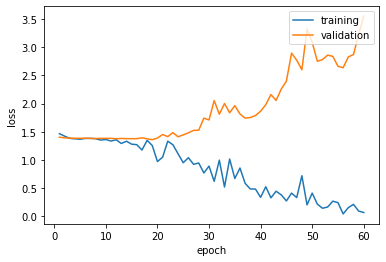

In [242]:
epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Generating predictions from validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


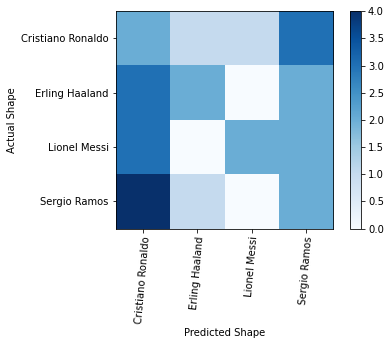

In [243]:
print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


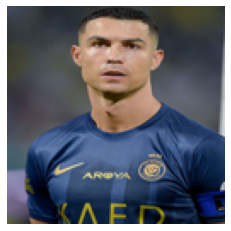

Erling Haaland


In [244]:
# Function to predict the class of an image
def predict_image(classifier, image_path):

    # Load the image
    image = Image.open(image_path)
    image = image.resize((128, 128))  # Adjust the size as needed

    # Convert the image to a NumPy array
    img_array = img_to_array(image)
    
    # Add an extra dimension to the array to match the expected input shape of the model
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the pixel values (like in the data generator)
    img_array = img_array.astype('float32') / 255.0
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(img_array)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])

    # Display the image
    plt.imshow(image) 
    plt.axis('off')
    plt.show()
    
    return index
# Create a random test image
classnames = os.listdir(os.path.join('..', '..', 'img', 'jugadores'))
classnames.sort()
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
index1 = predict_image(model, '../../img/prueba/1.jpg')

print (classnames[index1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


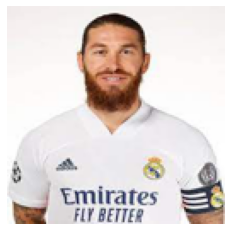

Sergio Ramos


In [245]:
# Use the classifier to predict the class
index2 = predict_image(model, '../../img/prueba/2.jpg')

print (classnames[index2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


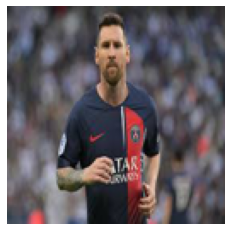

Lionel Messi


In [246]:
# Use the classifier to predict the class
index3 = predict_image(model, '../../img/prueba/3.jpg')

print (classnames[index3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


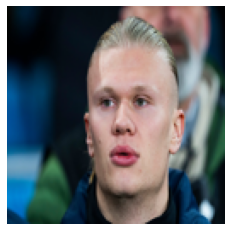

Lionel Messi


In [247]:
# Use the classifier to predict the class
index4 = predict_image(model, '../../img/prueba/4.jpg')

print (classnames[index4])